I used several pretrained models (Xception, VGG19, MobileNetV2, EfficientNetB2, ResNet50) and a custom CNN model but haven't obtained a good result in respect of classification metrics (AUC, Precision, Recall and F1).

I have used the following methods.

* 5 Kfold cross-validation,
* Used tf.data for input pipeline,
* Data augmentation,

## My Another Projects
* [Maize Classification w/Custom ResNet18 (AUC 0.928)](https://www.kaggle.com/code/banddaniel/maize-classification-w-custom-resnet18-auc-0-928)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Crop Water Quality Clf (ROC AUC 0.7) w/CatBoost](https://www.kaggle.com/code/banddaniel/crop-water-quality-clf-roc-auc-0-7-w-catboost)

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer,Input,SeparableConv2D, Conv2D, Add, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import  Dense, Dropout, Activation, BatchNormalization, Flatten


SEED = 5
BATCH_SIZE = 32
IMG_SIZE = 128,128
EPOCHS = 50

# <span style="color:#e74c3c;"> Preprocessing </span>


In [2]:
def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


train_no_beard = create_images_list('/kaggle/input/beard-or-no-beard/Beard or No Beared/Train/No Beard')
train_beard = create_images_list('/kaggle/input/beard-or-no-beard/Beard or No Beared/Train/Beard')

val_no_beard = create_images_list('/kaggle/input/beard-or-no-beard/Beard or No Beared/Validate/No Beard')
val_beard = create_images_list('/kaggle/input/beard-or-no-beard/Beard or No Beared/Validate/Beard')

test_no_beard = create_images_list('/kaggle/input/beard-or-no-beard/Beard or No Beared/Test/No Beard')
test_beard = create_images_list('/kaggle/input/beard-or-no-beard/Beard or No Beared/Test/Beard')


# look-up table
classes = {0:'no_beard', 1 : 'beard'}


data = pd.concat([ pd.DataFrame({'img':train_beard, 'label': 1 }),
                         pd.DataFrame({'img':train_no_beard, 'label': 0 }),
                         pd.DataFrame({'img':val_beard, 'label': 1 }),
                         pd.DataFrame({'img':val_no_beard, 'label': 0 }),
                         pd.DataFrame({'img':test_beard, 'label': 1 }),
                         pd.DataFrame({'img':test_no_beard, 'label': 0 }) ])


data = shuffle(data, random_state = SEED).reset_index(drop = True)

In [3]:
# Reading and resizing images
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size =  (IMG_SIZE) )
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Basic data augmentation - randomly flips up or down
def img_augmentation(image, label):

    radn_num = np.random.randint(0, 100)
    if radn_num % 2 == 0:
        img = tf.image.random_flip_up_down(image)
        return img, label
    else:
        return image, label
    
    if radn_num % 3 == 0:
        img = tf.image.random_flip_left_right(image)
        return img, label
    else:
        return image, label

# <span style="color:#e74c3c;"> VGG19 </span> Model


In [4]:
pretrained_model = tf.keras.applications.VGG19(weights='imagenet',include_top=False ,input_shape=[*IMG_SIZE, 3])
pretrained_model.trainable = True
    
model = tf.keras.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    
    Dense(256, activation = 'relu'),
    Dropout(0.3),
    
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid') 
    ])
    
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics  = ['Accuracy', 'AUC', 'Precision', 'Recall'])

80134624/80134624 [==============================] - 0s 0us/step


In [5]:
# A function that creating 4 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(sample_take, pred, id_):
    idxs = np.random.permutation(len(pred))[:4]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,4, figsize = (12, 4) ,dpi = 100)
    fig.suptitle('{0}.fold test predictions '.format(id_), fontsize=15)

    for i in range(4):
        img = sample_take[batch_idx[i]][0][image_idx[i]]
        label = sample_take[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img , cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img , cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

# <span style="color:#e74c3c;"> Training </span> 


---------------------------------------------------------------------------
1.fold starting
1/1 [==============================] - 1s 1s/step
Test precision 0.18778
Test recall 0.43333
Test F1 Score 0.26202
Test Accuracy 43.33 %
---------------------------------------------------------------------------
2.fold starting
1/1 [==============================] - 0s 96ms/step
Test precision 0.11111
Test recall 0.33333
Test F1 Score 0.16667
Test Accuracy 33.33 %
---------------------------------------------------------------------------
3.fold starting
1/1 [==============================] - 0s 185ms/step
Test precision 0.32111
Test recall 0.56667
Test F1 Score 0.40993
Test Accuracy 56.67 %
---------------------------------------------------------------------------
4.fold starting
1/1 [==============================] - 0s 103ms/step
Test precision 0.16000
Test recall 0.40000
Test F1 Score 0.22857
Test Accuracy 40.00 %
---------------------------------------------------------------------------


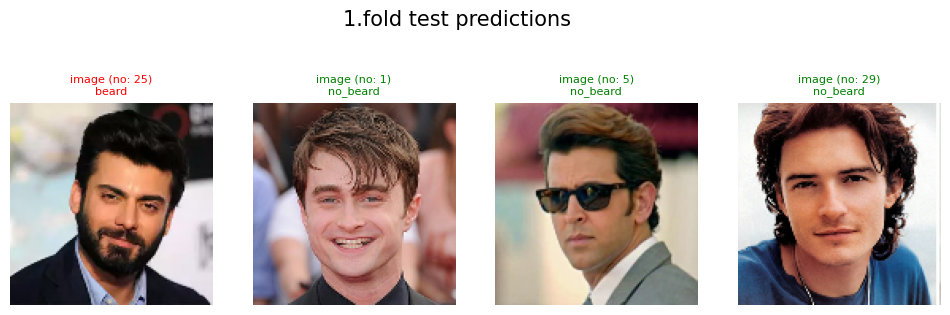

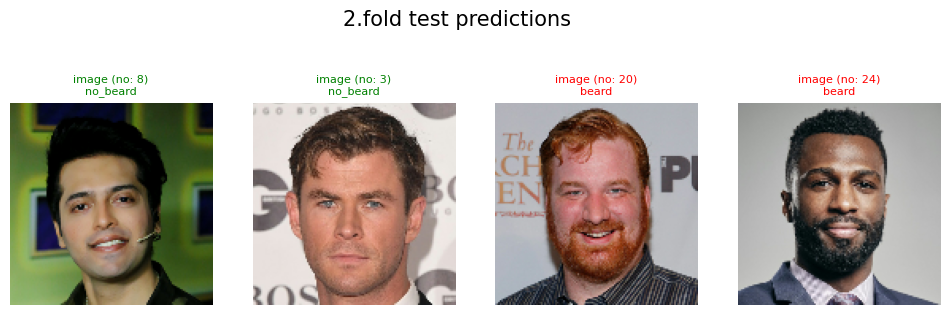

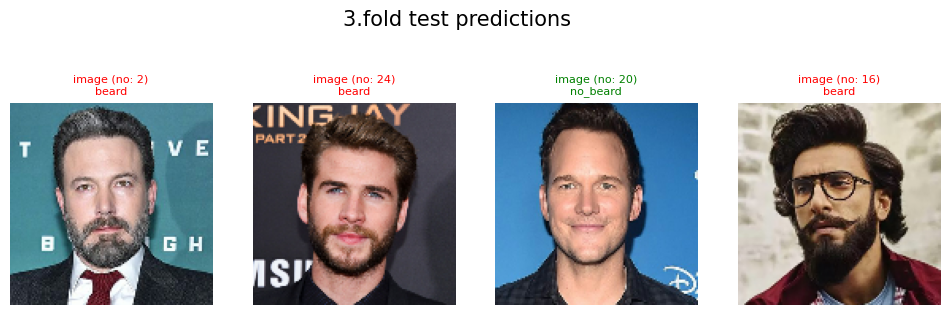

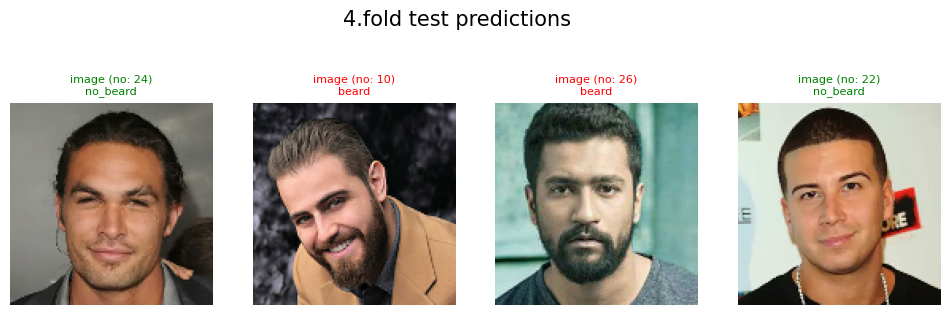

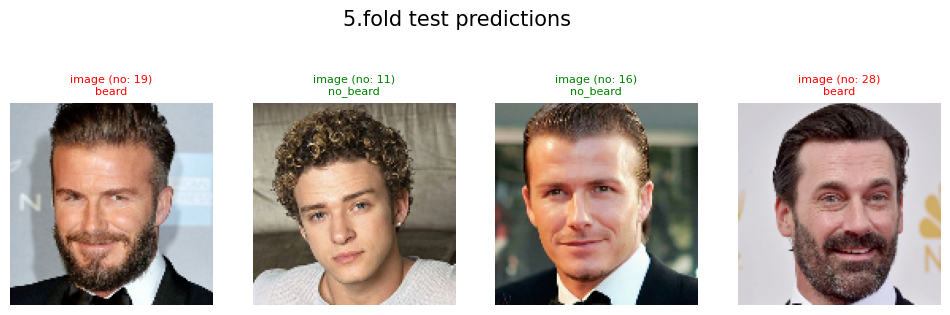

In [6]:
fold_hists = []
test_f1_scores = []
test_precision_scores = []
test_recall_scores = []
test_accuracy_scores = []

    
kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)
    
for i, (train_index, test_index) in enumerate(kf.split(data['img'],  data['label'])):
    
    print('-'*75)
    print(str(i+1) + '.fold starting')

    X_train_fold = data['img'][train_index]
    y_train_fold = data['label'][train_index]
    
    X_test_fold = data['img'][test_index]
    y_test_fold = data['label'][test_index]
    
    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing)
                     .map(img_augmentation)
                     .batch(BATCH_SIZE)
                     .prefetch(BATCH_SIZE))
    
    test_loader = tf.data.Dataset.from_tensor_slices((X_test_fold, y_test_fold))
    test_dataset = (test_loader
                    .map(img_preprocessing)
                    .batch(BATCH_SIZE)
                    .prefetch(BATCH_SIZE))
    
    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 0)
    fold_hists.append(hist)
    
    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    pred = np.argmax(pred, axis = 1)
    
    random_test_sample_with_prediction(test_take1_ ,pred ,i+1) # plotting random predictions from test set
    
    # Classification metrics
    
    test_precision = precision_score(y_test_fold, pred, average = 'weighted')
    test_recall = recall_score(y_test_fold, pred, average = 'weighted')
    test_f1 = f1_score(y_test_fold, pred, average = 'weighted')
    test_accuracy_score = accuracy_score(y_test_fold, pred)
    
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_f1_scores.append(test_f1)
    test_accuracy_scores.append(test_accuracy_score)

    print('Test precision {0:.5f}'.format(test_precision))
    print('Test recall {0:.5f}'.format(test_recall))
    print('Test F1 Score {0:.5f}'.format(test_f1))
    print('Test Accuracy {0:.2f} %'.format(test_accuracy_score * 100))

# <span style="color:#e74c3c;"> Test </span> Results


In [7]:
results = pd.DataFrame({'test_recall_score': test_recall_scores, 'test_precision_score' : test_precision_scores,
                        'test_f1_scores': test_f1_scores, 'test_accuracy':test_accuracy_scores  })

results.index = ['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5']

results

,test_recall_score,test_precision_score,test_f1_scores,test_accuracy
fold 1,0.433333,0.187778,0.262016,0.433333
fold 2,0.333333,0.111111,0.166667,0.333333
fold 3,0.566667,0.321111,0.409929,0.566667
fold 4,0.400000,0.160000,0.228571,0.400000
fold 5,0.448276,0.200951,0.277504,0.448276
